# 学习内容

+ fastai.text.all提供了以下功能函数
    - RandomSplitter: Split the data in a trainig and validation set
    - DataLoader: https://docs.fast.ai/data.load.html
    - layers: https://fastai1.fast.ai/layers.html
+ transformers
    - AutoTokenizer: This is a generic tokenizer class that will be instantiated as one of the tokenizer classes of the library when created with the AutoTokenizer.from_pretrained() class method.
    - AutoModelForSequenceClassification: This is a generic model class that will be instantiated as one of the model classes of the library (with a sequence classification head) when created with the from_pretrained() class method or the from_config() class method.

In [ ]:
# Importing the libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from fastai.text.all import *
import numpy as np
import pandas as pd

# Data Import
df = pd.DataFrame([{'text': ''}])

# Data Process
class Dataset:
    def __init__(self, tensors, target, ids):
        self.text = tensors[ids]
        self.targ = target[ids].reset_index(drop=True)
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        t = self.text[idx]
        y = self.target[idx]
        return t, tensor(y)

# tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# tensor
train_tensor = tokenizer(list(train_df["text"]), padding="max_length", truncation=True, max_length=30, return_tensors="pt")["input_ids"]

# Split the data in a trainig and validation set
train_ids, valid_ids = RandomSplitter()(train_df)

# Separate the y / target into a variable
target = train_df["target"]

# create the input dataset based on the randomsplitter ids and utiliing the pre-processed tokens 
train_ds = Dataset(train_tensor, target, train_ids)
valid_ds = Dataset(train_tensor, target, valid_ids)

train_dl = DataLoader(train_ds, bs=64)
valid_dl = DataLoader(valid_ds, bs=512)

dls = DataLoaders(train_dl, valid_dl)


# Model
# Instantiate model object (Bert model with classification output)
bert = AutoModelForSequenceClassification.from_pretrained("bert-base-cased").train()

classifier = nn.Sequential(
    nn.Linear(768, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Dropout(0.5),
    nn.Linear(300, 2)
)

bert.classifier = classifier

class BertClassifier(Module):
    def __init__(self, bert):
        self.bert = bert
    def forward(self, x):
        return self.bert(x).logits

model = BertClassifier(bert)


# Train
# Set up the fastai learner using the model insantiated in previous step and find optimal learning rate
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy, F1Score()])
learn.lr_find()

# Fit the model
learn.fit_one_cycle(4, lr_max=5e-5, wd=0.8)

preds, targs = learn.get_preds()

# 正文部分

This notebook is a code-along note book that follows the following notebook by Pei-Yi Hong with additional comments to clarify each step for beginner learners like me :-)

https://www.kaggle.com/hongpeiyi/bert-with-pytorch-and-fastai 

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
from fastai.text.all import *
import re

In [2]:
# Loading the training and testing data into dataframes
dir_path = "./"
train_df = pd.read_csv(dir_path + "train.csv")
test_df = pd.read_csv(dir_path + "test.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
# Keep only the text and target columnds
traind_df = train_df.drop(columns = ["id", "keyword", "location"])
traind_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [5]:
# Cleaning the text data: removing URLs, html code and emoji
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df["text"] = train_df["text"].apply(remove_URL)
train_df["text"] = train_df["text"].apply(remove_html)
train_df["text"] = train_df["text"].apply(remove_emoji)

test_df["text"] = test_df["text"].apply(remove_URL)
test_df["text"] = test_df["text"].apply(remove_html)
test_df["text"] = test_df["text"].apply(remove_emoji)

<AxesSubplot:ylabel='Frequency'>

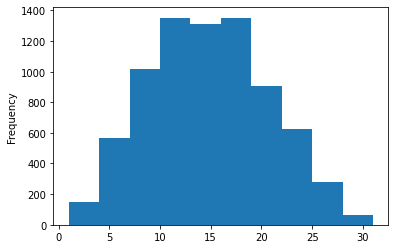

In [6]:
train_df["text"].apply(lambda x:len(x.split())).plot(kind="hist")

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [8]:
# Instantiate a tokenizer based on the Bert case sensitive model 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [9]:
# Convert text sequences to numerical tokens (vector of numbers which can be fed into the model)

train_tensor = tokenizer(list(train_df["text"]), padding="max_length", 
                         truncation=True, max_length=30, 
                         return_tensors="pt")["input_ids"]

In [11]:
# Create a custom class to prepare the training data to be 
# in model input form (tuple of tokenized text sequence and tensor of target)

class TweetDataset:
    def __init__(self, tensors, targ, ids):
        self.text = tensors[ids]
        self.targ = targ[ids].reset_index(drop=True)
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        t = self.text[idx]
        y = self.targ[idx]
        return t, tensor(y)

In [18]:
# Split the data in a trainig and validation set
train_ids, valid_ids = RandomSplitter()(train_df)

# Separate the y / target into a variable
target = train_df["target"]

# create the input dataset based on the randomsplitter ids and utiliing the pre-processed tokens 
train_ds = TweetDataset(train_tensor, target, train_ids)
valid_ds = TweetDataset(train_tensor, target, valid_ids)

train_dl = DataLoader(train_ds, bs=64)
valid_dl = DataLoader(valid_ds, bs=512)

dls = DataLoaders(train_dl, valid_dl)

In [19]:
# Instantiate model object (Bert model with classification output)

bert = AutoModelForSequenceClassification.from_pretrained("bert-base-cased").train()

classifier = nn.Sequential(
    nn.Linear(768, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Dropout(0.5),
    nn.Linear(300, 2)
)

bert.classifier = classifier

class BertClassifier(Module):
    def __init__(self, bert):
        self.bert = bert
    def forward(self, x):
        return self.bert(x).logits

model = BertClassifier(bert)
    

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=0.0002754228771664202)

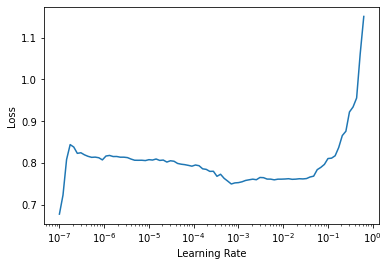

In [20]:
# Set up the fastai learner using the model insantiated in previous step and find optimal learning rate

learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy, F1Score()])
learn.lr_find()

In [21]:
# Fit the model
learn.fit_one_cycle(4, lr_max=5e-5, wd=0.8)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.616266,0.467299,0.805519,0.763578,27:48
1,0.440400,0.460923,0.825230,0.780165,22:48
2,0.319835,0.507775,0.824573,0.780608,21:06
3,0.232370,0.520090,0.813403,0.777080,20:30


In [22]:
# Check f1 scores if threshold for for the probability of the logit 
# with the highest probability is above a minimum threshold 
# (if logits is below this threshold, I believe the prediction is zero: "not a disaster tweet") 

from sklearn.metrics import f1_score

preds, targs = learn.get_preds()

min_threshold = None
max_f1 = -float("inf")
thresholds = np.linspace(0.3, 0.7, 50)
for threshold in thresholds:
    f1 = f1_score(targs, F.softmax(preds, dim=1)[:, 1]>threshold)
    if f1 > max_f1:
        min_threshold = threshold
        min_f1 = f1
    print(f"thresholds:{threshold:.4f} - f1:{f1:.4f}")

thresholds:0.3000 - f1:0.7594
thresholds:0.3082 - f1:0.7604
thresholds:0.3163 - f1:0.7606
thresholds:0.3245 - f1:0.7613
thresholds:0.3327 - f1:0.7620
thresholds:0.3408 - f1:0.7643
thresholds:0.3490 - f1:0.7636
thresholds:0.3571 - f1:0.7659
thresholds:0.3653 - f1:0.7649
thresholds:0.3735 - f1:0.7655
thresholds:0.3816 - f1:0.7672
thresholds:0.3898 - f1:0.7672
thresholds:0.3980 - f1:0.7681
thresholds:0.4061 - f1:0.7691
thresholds:0.4143 - f1:0.7721
thresholds:0.4224 - f1:0.7735
thresholds:0.4306 - f1:0.7741
thresholds:0.4388 - f1:0.7771
thresholds:0.4469 - f1:0.7783
thresholds:0.4551 - f1:0.7795
thresholds:0.4633 - f1:0.7776
thresholds:0.4714 - f1:0.7782
thresholds:0.4796 - f1:0.7800
thresholds:0.4878 - f1:0.7797
thresholds:0.4959 - f1:0.7793
thresholds:0.5041 - f1:0.7771
thresholds:0.5122 - f1:0.7780
thresholds:0.5204 - f1:0.7760
thresholds:0.5286 - f1:0.7763
thresholds:0.5367 - f1:0.7769
thresholds:0.5449 - f1:0.7787
thresholds:0.5531 - f1:0.7794
thresholds:0.5612 - f1:0.7735
thresholds

In [23]:
# Convert text sequences to numerical tokens (vector of numbers which can be fed into the model)

test_tensor = tokenizer(list(test_df["text"]),
                        padding="max_length",
                        truncation=True,
                        max_length=30,
                        return_tensors="pt")["input_ids"]

In [24]:
# Create a custom class to prepare the test data in the input form required for the model: a tuple
# of text sequence and a tensor of zero

class TestDS:
    def __init__(self, tensors):
        self.tensors = tensors
    
    def __len__(self):
        return len(self.tensors)
    
    def __getitem__(self, idx):
        t = self.tensors[idx]
        return t, tensor(0)

test_dl = DataLoader(TestDS(test_tensor), bs=128)

In [25]:
# Get test prediction from the learner model

test_preds = learn.get_preds(dl=test_dl)

In [26]:
# Submit output to Kaggle
prediction = (F.softmax(test_preds[0], dim=1)[:, 1]>min_threshold).int()
sub = pd.read_csv(dir_path + "sample_submission.csv")
sub["target"] = prediction
sub.to_csv("submission.csv", index=False)